In [1]:
import os
import time
import numpy as np
import pandas as pd
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, GroupShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
import math

def quaternion_to_euler(x, y, z, w):

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = np.sqrt(np.square(actual['angular_velocity_X']) + 
                                        np.square(actual['angular_velocity_Y']) + 
                                        np.square(actual['angular_velocity_Z']))
    actual['total_linear_acceleration'] = np.sqrt(np.square(actual['linear_acceleration_X']) + 
                                            np.square(actual['linear_acceleration_Y']) + 
                                            np.square(actual['linear_acceleration_Z']))
    
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    def f1(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    def f2(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(f2)
        
        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(f1)
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new


X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
SS = pd.read_csv('sample_submission.csv')

X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [2]:
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])

X_train = fe(X_train)
X_test = fe(X_test)

# Imputation   
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace = True)

X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_test.replace(-np.inf, 0, inplace = True)
X_test.replace(np.inf, 0, inplace = True)
X_train.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,...,euler_y_abs_min,euler_z_mean,euler_z_min,euler_z_max,euler_z_std,euler_z_max_to_min,euler_z_mean_abs_change,euler_z_mean_change_of_abs_change,euler_z_abs_max,euler_z_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,...,0.023562,1.396035,1.393233,1.397402,0.001221,1.002992,0.000051,1.602451e-07,1.397402,1.393233
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,...,0.009109,-0.492731,-0.494641,-0.490164,0.001131,0.990949,0.000147,1.303804e-07,0.494641,0.490164
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,...,0.011795,2.055021,2.049684,2.061288,0.003219,1.005661,0.000097,-8.169853e-07,2.061288,2.049684
3,-0.939169,-0.93968,-0.93884,0.000227,0.999106,0.000026,-6.349206e-07,0.93968,0.93884,0.310140,...,0.014645,-0.635656,-0.638340,-0.634294,0.000931,0.993661,0.000071,9.790398e-08,0.638340,0.634294
4,-0.891301,-0.89689,-0.88673,0.002955,0.988672,0.000080,7.936508e-08,0.89689,0.88673,0.428144,...,0.009358,-0.894147,-0.915040,-0.867983,0.013836,0.948575,0.000371,4.805791e-07,0.915040,0.867983


In [3]:
'''
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest Accuracy: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))

# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = RandomForestClassifier(
        criterion='gini',
        verbose=1,
        max_features='auto',
        max_leaf_nodes=None,
        random_state = 1337
        
    ),
    search_spaces = { 
        'max_depth': (1, 200),
        'n_estimators': (20, 300),
        'min_samples_split': (2,20),
        'min_samples_leaf': (1,10),
        'min_weight_fraction_leaf': (0.0,0.5),
        'min_impurity_decrease': (0,1E-7),
        
        
    },    
    cv = GroupShuffleSplit(n_splits=5, random_state = 1337),
    n_jobs = -1,
    n_iter = 40,   
    verbose = 1,
    refit = True,
    
)

# Fit the model
result = bayes_cv_tuner.fit(X_train, y_train['surface'], groups=y_train['group_id'], callback=status_print)
'''

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #1
Best Accuracy: 0.372
Best params: {'max_depth': 17, 'min_impurity_decrease': 8.358798660377378e-08, 'min_samples_leaf': 8, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.4330963281329311, 'n_estimators': 166}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #2
Best Accuracy: 0.3723
Best params: {'max_depth': 41, 'min_impurity_decrease': 6.367575944513938e-08, 'min_samples_leaf': 2, 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.35145356433327507, 'n_estimators': 61}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #3
Best Accuracy: 0.3723
Best params: {'max_depth': 41, 'min_impurity_decrease': 6.367575944513938e-08, 'min_samples_leaf': 2, 'min_samples_split': 14, 'min_weight_fraction_leaf': 0.35145356433327507, 'n_estimators': 61}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Model #4
Best Accuracy: 0.5026
Best params: {'max_depth': 152, 'min_impurity_decrease': 5.826604178183534e-08, 'min_samples_leaf': 2, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.020309698287030168, 'n_estimators': 283}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #5
Best Accuracy: 0.5026
Best params: {'max_depth': 152, 'min_impurity_decrease': 5.826604178183534e-08, 'min_samples_leaf': 2, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.020309698287030168, 'n_estimators': 283}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #6
Best Accuracy: 0.5026
Best params: {'max_depth': 152, 'min_impurity_decrease': 5.826604178183534e-08, 'min_samples_leaf': 2, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.020309698287030168, 'n_estimators': 283}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #7
Best Accuracy: 0.5026
Best params: {'max_depth': 152, 'min_impurity_decrease': 5.826604178183534e-08, 'min_samples_leaf': 2, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.020309698287030168, 'n_estimators': 283}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model #8
Best Accuracy: 0.5026
Best params: {'max_depth': 152, 'min_impurity_decrease': 5.826604178183534e-08, 'min_samples_leaf': 2, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.020309698287030168, 'n_estimators': 283}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Model #9
Best Accuracy: 0.5026
Best params: {'max_depth': 152, 'min_impurity_decrease': 5.826604178183534e-08, 'min_samples_leaf': 2, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.020309698287030168, 'n_estimators': 283}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Model #10
Best Accuracy: 0.5026
Best params: {'max_depth': 152, 'min_impurity_decrease': 5.826604178183534e-08, 'min_samples_leaf': 2, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.020309698287030168, 'n_estimators': 283}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


Model #11
Best Accuracy: 0.5047
Best params: {'max_depth': 200, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Model #12
Best Accuracy: 0.5091
Best params: {'max_depth': 137, 'min_impurity_decrease': 8.95323400200393e-08, 'min_samples_leaf': 10, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 35}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Model #13
Best Accuracy: 0.5182
Best params: {'max_depth': 16, 'min_impurity_decrease': 4.356924164818867e-09, 'min_samples_leaf': 9, 'min_samples_split': 17, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 170}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Model #14
Best Accuracy: 0.5182
Best params: {'max_depth': 16, 'min_impurity_decrease': 4.356924164818867e-09, 'min_samples_leaf': 9, 'min_samples_split': 17, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 170}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Model #15
Best Accuracy: 0.5182
Best params: {'max_depth': 16, 'min_impurity_decrease': 4.356924164818867e-09, 'min_samples_leaf': 9, 'min_samples_split': 17, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 170}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Model #16
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Model #17
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished


Model #18
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Model #19
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


Model #20
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Model #21
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Model #22
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Model #23
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Model #24
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Model #25
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Model #26
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Model #27
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Model #28
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Model #29
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


Model #30
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Model #31
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Model #32
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Model #33
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


Model #34
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Model #35
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


Model #36
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Model #37
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished


Model #38
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished


Model #39
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Model #40
Best Accuracy: 0.5185
Best params: {'max_depth': 194, 'min_impurity_decrease': 2.2948068489142796e-08, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210}



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    5.3s finished


In [4]:
folds = GroupShuffleSplit(n_splits=3, random_state=1337)
sub_preds = np.zeros((X_test.shape[0], 9))
score_sum = 0
'''
clf = LGBMClassifier(colsample_bytree=0.03581900508076567, learning_rate=0.09308743154192588, 
                     max_bin=471, max_depth=-1, min_child_samples=50, min_child_weight=10, 
                     n_estimators=51, num_leaves=82, reg_alpha=2.0036361362515476e-07, reg_lambda=0.2069846982564452,
                     scale_pos_weight=9.05248363351552, subsample=0.9056112605172989, subsample_for_bin=368683, 
                     subsample_freq=9)
'''
# clf = XGBClassifier() 
'''
clf = RandomForestClassifier(max_depth=77, min_impurity_decrease=8.435373293206687e-08, 
                             min_samples_leaf=10, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=170, random_state=1337)
'''
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):

    print('_'*20, i, '_'*20)
    clf.fit(X_train.iloc[train_index], y_train['surface'][train_index])
    score_sum += clf.score(X_train.iloc[test_index], y_train['surface'][test_index])
    print('train_score ', clf.score(X_train.iloc[train_index], y_train['surface'][train_index]))
    print('cv_score ', clf.score(X_train.iloc[test_index], y_train['surface'][test_index]))
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns
    
    '''
    hm = 30
    plt.figure(figsize=(7, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    '''
    

print('_'*40)
mean_cv_acc = score_sum / folds.n_splits
print('Avg CV Accuracy', mean_cv_acc)
clf.fit(X_train, y_train['surface'])
sub_preds = clf.predict_proba(X_test)
SS['surface'] = le.inverse_transform(sub_preds.argmax(axis=1))
SS.to_csv('rf.csv', index=False)

____________________ 0 ____________________
train_score  0.9195548489666137
cv_score  0.518796992481203
____________________ 1 ____________________
train_score  0.9294578706727629
cv_score  0.5762032085561497
____________________ 2 ____________________
train_score  0.9161028416779432
cv_score  0.42857142857142855
________________________________________
Avg CV Accuracy 0.5078572098695938


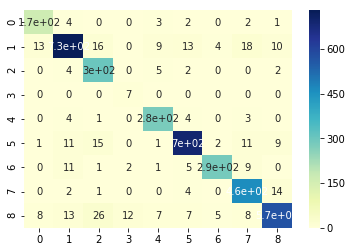

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(clf.predict(X_train), y_train['surface'])
sns.heatmap(cm, annot=True, cmap="YlGnBu")

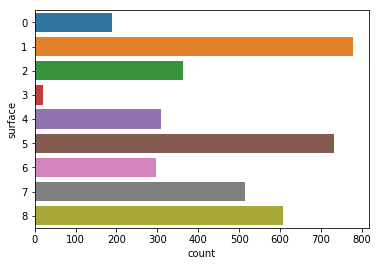

In [6]:
countplot(y = 'surface', data = y_train)
plt.show()

In [7]:
print(y_train['surface'].value_counts())

1    779
5    732
8    607
7    514
2    363
4    308
6    297
0    189
3     21
Name: surface, dtype: int64


In [8]:
print(le.inverse_transform(y_train['surface'].unique()))
print(y_train['surface'].unique())

['fine_concrete' 'concrete' 'soft_tiles' 'tiled' 'soft_pvc'
 'hard_tiles_large_space' 'carpet' 'hard_tiles' 'wood']
[2 1 6 7 5 4 0 3 8]


In [9]:
print("Training group id counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):
    print((y_train['group_id'].iloc[train_index]).value_counts())
    
print("\n\nCV group id counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):    
    print((y_train['group_id'].iloc[test_index]).value_counts())
    
print("\n\nTraining label counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):
    print((y_train['surface'].iloc[train_index]).value_counts())
    
print("\n\nCV label counts.")    
for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train['surface'],
                                                groups=y_train['group_id'])):    
    print((y_train['surface'].iloc[test_index]).value_counts())

Training group id counts.
70    71
60    71
53    71
44    71
40    71
71    70
69    70
68    70
62    70
54    70
48    70
46    70
42    70
38    70
39    70
41    70
43    70
45    70
47    70
55    70
61    70
65    70
72    70
59    64
34    57
12    57
18    57
26    57
15    57
3     57
8     57
4     57
35    57
33    57
29    57
20    57
19    57
22    57
9     57
23    56
14    56
7     56
10    56
11    56
31    54
25    51
6     48
57    41
1     38
27    21
2     18
63    17
17    12
50    10
58     7
67     6
24     5
30     3
Name: group_id, dtype: int64
70    71
60    71
44    71
40    71
71    70
41    70
48    70
46    70
42    70
38    70
69    70
72    70
43    70
45    70
55    70
61    70
65    70
59    64
66    64
49    60
51    60
18    57
22    57
26    57
34    57
12    57
4     57
20    57
0     57
3     57
9     57
35    57
33    57
15    57
29    57
19    57
23    56
7     56
11    56
10    56
31    54
64    53
25    51
6     48
16    45
57    41
1     38
